In [ ]:
pip install git+https://github.com/qubvel/segmentation_models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/qubvel/segmentation_models to /tmp/pip-req-build-8_pclzls
  Running command git clone -q https://github.com/qubvel/segmentation_models /tmp/pip-req-build-8_pclzls
  Running command git submodule update --init --recursive -q
     |████████████████████████████████| 50 kB 3.2 MB/s 
  Created wheel for segmentation-models: filename=segmentation_models-1.0.1-py3-none-any.whl size=33810 sha256=552f3479f29a6a34eac25d5db6de01d265cfcbbf4c03280f97fd24f734ae39fe
  Stored in directory: /tmp/pip-ephem-wheel-cache-l6ohjeml/wheels/02/cd/18/61c0bbb8766acfec68f9d20618886b7b38dfeeb95865b6ba00
Successfully built segmentation-models


In [ ]:
import warnings
warnings.filterwarnings("ignore")
import keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, UpSampling3D, Conv2DTranspose, concatenate
from tensorflow.keras.layers import BatchNormalization
from keras.backend import set_session
from keras.backend import clear_session
from keras.backend import get_session


import numpy as np
from numpy import unravel_index
import pandas as pd

from os import listdir
import os, os.path

import glob

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import skimage.measure
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
from sklearn.metrics import r2_score

from PIL import Image

import re
import gc

import time

In [ ]:
import segmentation_models as sm

sm.set_framework('tf.keras')

sm.framework()

Segmentation Models: using `keras` framework.


'tf.keras'

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Loaded: data_2_105_74
(200, 96, 96, 3)
Loaded: data_2_91_89
(200, 96, 96, 3)
Loaded: data_2_115_65
(200, 96, 96, 3)
Loaded: data_4_105_74
(200, 96, 96, 3)
Loaded: data_4_115_65
(200, 96, 96, 3)
Loaded: data_6_105_74
(200, 96, 96, 3)
Loaded: data_4_91_89
(200, 96, 96, 3)
Loaded: data_6_91_89
(200, 96, 96, 3)
Loaded: data_6_115_65
(200, 96, 96, 3)
0.0
1.0


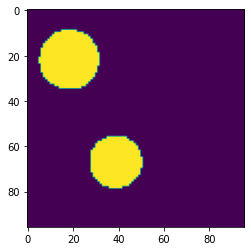

In [ ]:
filepath = '/content/drive/MyDrive/Research_FractureStressMLModeling/FractureStressColab/ColabData/High_Porosity/3-channel data/Non_Uniform_Sized_Pores/Images96x96_newData(Normalized_maxpool_3D)'
imageDict = {}
for filename in os.listdir(filepath):
    path = os.path.join(filepath, filename)
    key = filename.split('.')[0]
    imageDict[key] = np.load(path,allow_pickle=True)
    print('Loaded: '+ key)
    print(imageDict[key].shape)


plt.imshow(imageDict['data_2_105_74'][70,:,:,0])
print(imageDict['data_2_105_74'][70].min())
print(imageDict['data_2_105_74'][70].max())

Loaded: data_2_115_65
(200, 96, 96, 3)
Loaded: data_2_105_74
(200, 96, 96, 3)
Loaded: data_4_105_74
(200, 96, 96, 3)
Loaded: data_2_91_89
(200, 96, 96, 3)
Loaded: data_4_91_89
(200, 96, 96, 3)
Loaded: data_4_115_65
(200, 96, 96, 3)
Loaded: data_6_115_65
(200, 96, 96, 3)
Loaded: data_6_105_74
(200, 96, 96, 3)
Loaded: data_6_91_89
(200, 96, 96, 3)
-0.07724143392053406
4.328437686141806


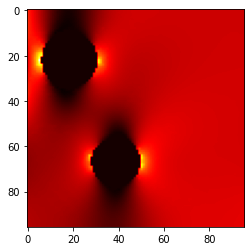

In [ ]:
DIR = '/content/drive/MyDrive/Research_FractureStressMLModeling/FractureStressColab/ColabData/High_Porosity/3-channel data/Non_Uniform_Sized_Pores/Stress96x96_newData(Normalized_maxpool_3D)'
matrixDict = {}
for filename in os.listdir(DIR):
    path = os.path.join(DIR, filename)
    key = filename.split('.')[0]
    matrixDict[key] = np.load(path)
    print('Loaded: '+ key)
    print(matrixDict[key].shape)
    
plt.imshow(matrixDict['data_2_105_74'][70][:,:,0], cmap='hot')
print(matrixDict['data_2_105_74'][70].min())
print(matrixDict['data_2_105_74'][70].max())

In [ ]:
# Combine X datas
x = np.concatenate((imageDict['data_2_105_74'], imageDict['data_2_115_65'],
                    imageDict['data_2_91_89'],imageDict['data_4_105_74'],imageDict['data_4_115_65'],
                    imageDict['data_4_91_89'], imageDict['data_6_91_89'], imageDict['data_6_105_74'],
                    imageDict['data_6_115_65'],), axis = 0)   
x.shape

(1800, 96, 96, 3)

In [ ]:
# Combine Y datas 
y = np.concatenate((matrixDict['data_2_105_74'], matrixDict['data_2_115_65'],
                    matrixDict['data_2_91_89'],matrixDict['data_4_105_74'],matrixDict['data_4_115_65'],
                    matrixDict['data_4_91_89'], matrixDict['data_6_91_89'], matrixDict['data_6_105_74'],
                    matrixDict['data_6_115_65'],), axis = 0) 
y.shape

(1800, 96, 96, 3)

In [ ]:
# Since there are total 1100 images,
# training data is 90% : 990
# testing data is 10% : 110
x_train, x_test, y_train, y_test = train_test_split(x, y,
                                                    test_size=0.1, 
                                                    random_state=42)

print('Shape of x_train',x_train.shape,'\n',
      'Shape of x_test',x_test.shape,'\n', 
      'Shape of y_train',y_train.shape,'\n', 
      'Shape of y_test',y_test.shape)

Shape of x_train (1620, 96, 96, 3) 
 Shape of x_test (180, 96, 96, 3) 
 Shape of y_train (1620, 96, 96, 3) 
 Shape of y_test (180, 96, 96, 3)


In [ ]:
# For observing effects of data size, 

idx = np.random.randint(1620, size=100)
x_train_100 = x_train[idx,:,:,:]
y_train_100 = y_train[idx,:,:,:]
print('Shape of x_train_100',x_train_100.shape,'\n',
      'Shape of y_train_100',y_train_100.shape,'\n')

idx = np.random.randint(1620, size=300)
x_train_300 = x_train[idx,:,:,:]
y_train_300 = y_train[idx,:,:,:]
print('Shape of x_train_300',x_train_300.shape,'\n',
      'Shape of y_train_300',y_train_300.shape,'\n')

idx = np.random.randint(1620, size=500)
x_train_500 = x_train[idx,:,:,:]
y_train_500 = y_train[idx,:,:,:]
print('Shape of x_train_500',x_train_500.shape,'\n',
      'Shape of y_train_500',y_train_500.shape,'\n')

idx = np.random.randint(1620, size=700)
x_train_700 = x_train[idx,:,:,:]
y_train_700 = y_train[idx,:,:,:]
print('Shape of x_train_700',x_train_700.shape,'\n',
      'Shape of y_train_700',y_train_700.shape,'\n')

idx = np.random.randint(1620, size=900)
x_train_900 = x_train[idx,:,:,:]
y_train_900 = y_train[idx,:,:,:]
print('Shape of x_train_900',x_train_900.shape,'\n',
      'Shape of y_train_900',y_train_900.shape,'\n')

idx = np.random.randint(1620, size=1100)
x_train_1100 = x_train[idx,:,:,:]
y_train_1100 = y_train[idx,:,:,:]
print('Shape of x_train_1100',x_train_1100.shape,'\n',
      'Shape of y_train_1100',y_train_1100.shape,'\n')

idx = np.random.randint(1620, size=1300)
x_train_1300 = x_train[idx,:,:,:]
y_train_1300 = y_train[idx,:,:,:]
print('Shape of x_train_1300',x_train_1300.shape,'\n',
      'Shape of y_train_1300',y_train_1300.shape,'\n')

x_train_1620 = np.copy(x_train)
y_train_1620 = np.copy(y_train)
print('Shape of x_train_1620',x_train_1620.shape,'\n',
      'Shape of y_train_1620',y_train_1620.shape)

Shape of x_train_100 (100, 96, 96, 3) 
 Shape of y_train_100 (100, 96, 96, 3) 

Shape of x_train_300 (300, 96, 96, 3) 
 Shape of y_train_300 (300, 96, 96, 3) 

Shape of x_train_500 (500, 96, 96, 3) 
 Shape of y_train_500 (500, 96, 96, 3) 

Shape of x_train_700 (700, 96, 96, 3) 
 Shape of y_train_700 (700, 96, 96, 3) 

Shape of x_train_900 (900, 96, 96, 3) 
 Shape of y_train_900 (900, 96, 96, 3) 

Shape of x_train_1100 (1100, 96, 96, 3) 
 Shape of y_train_1100 (1100, 96, 96, 3) 

Shape of x_train_1300 (1300, 96, 96, 3) 
 Shape of y_train_1300 (1300, 96, 96, 3) 

Shape of x_train_1620 (1620, 96, 96, 3) 
 Shape of y_train_1620 (1620, 96, 96, 3)


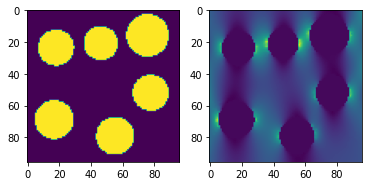

[[[1.5249252  1.5249252  1.5249252 ]
  [1.48792579 1.48792579 1.48792579]
  [1.45091231 1.45091231 1.45091231]
  ...
  [1.56441344 1.56441344 1.56441344]
  [1.58241971 1.58241971 1.58241971]
  [1.60043268 1.60043268 1.60043268]]

 [[1.52559007 1.52559007 1.52559007]
  [1.48853229 1.48853229 1.48853229]
  [1.45146045 1.45146045 1.45146045]
  ...
  [1.56413378 1.56413378 1.56413378]
  [1.58213343 1.58213343 1.58213343]
  [1.60013977 1.60013977 1.60013977]]

 [[1.51923394 1.51923394 1.51923394]
  [1.48557739 1.48557739 1.48557739]
  [1.45190678 1.45190678 1.45190678]
  ...
  [1.56563121 1.56563121 1.56563121]
  [1.5841638  1.5841638  1.5841638 ]
  [1.60270308 1.60270308 1.60270308]]

 ...

 [[2.14603851 2.14603851 2.14603851]
  [2.01526599 2.01526599 2.01526599]
  [1.88208001 1.88208001 1.88208001]
  ...
  [1.65971995 1.65971995 1.65971995]
  [1.6926222  1.6926222  1.6926222 ]
  [1.7234481  1.7234481  1.7234481 ]]

 [[2.13541858 2.13541858 2.13541858]
  [2.00677394 2.00677394 2.00677394]


In [ ]:
f = plt.figure()
f.add_subplot(1,2, 1)
plt.imshow(x_train_100[71][:,:,0])
f.add_subplot(1,2, 2)
plt.imshow(y_train_100[71][:,:,0])
plt.show(block=True)
print(y_train_100[70])

In [ ]:
# A function calculating Percentage Error
def percentage_err_3channels(y_pred, y_test):
    arr = []
    for idx in range(len(y_test)):
        for x in range(y_test.shape[1]):
            #for y in range(y_test.shape[2]):
            for z in range(y_test.shape[3]):
                if(0 in y_test[idx]):
                    continue
                else:
                    err = ((np.abs(y_pred[idx] - y_test[idx]) / y_test[idx]) * 100)
                    arr.append(err)
    
    return abs(np.mean(arr))

# A function calculating Percentage Error with 1-channel
def percentage_err_1channel(y_pred, y_test): 
    arr = []
    for idx in range(len(y_test)):
        for x in range(y_test.shape[1]):
            #for y in range(y_test.shape[2]):
            if(0 in y_test[idx,x,:]):
                continue
            else:
                err = ((np.abs(y_pred[idx] - y_test[idx]) / y_test[idx]) * 100)
                arr.append(err)
    
    return np.mean(arr)

# A Function to calculate R2 for each pore
def calculateR2_for_pores(preds, y_test, AVMat):
    b = []
    c = []
    TSS = 0
    RSS = 0
    
    for i in range(len(y_test)):
        b = ((y_test[i] - preds[i])**2)
        RSS = RSS + b
        
    for i in range(len(y_test)):
        c = ((y_test[i] -  AVMat)**2)
        TSS = TSS + c

    R2 = 1 - (RSS/TSS)
    return R2.mean()
    
# A function to obtain AVMat
def calculateAVMat(y_test):
    AVMat = np.zeros((96,96,3))

    for i in range(len(y_test)):
        AVMat = AVMat + (y_test[i])
    
    AVMat = AVMat/len(y_test)
    
    return AVMat

# A function calculates R2 score
def calculateR2(preds, y_test):
    b = []
    c = []
    TSS = 0
    RSS = 0
    AVMat = np.zeros((96,96,3))

    for i in range(len(y_test)):
        AVMat = AVMat + (y_test[i])

    AVMat = AVMat/len(y_test)

    for i in range(len(y_test)):
        b = ((y_test[i] - preds[i])**2)
        RSS = RSS + b

    for i in range(len(y_test)):
        c = ((y_test[i] -  AVMat)**2)
        TSS = TSS + c

    R2 = 1 - (RSS/TSS)
    return R2.mean()

# A function calculates MSE
def calculateMSE(dataA, dataB):
    errArray = []
    for i in range(len(dataA)):
        err = np.sum((dataA[i] - dataB[i]) ** 2)
        err /= float(dataA[i].shape[0] * dataA[i].shape[1])
        errArray.append(err)

    return sum(errArray) / len(errArray)

In [ ]:
# Function reset the model
def reset_keras(model):
    sess = tf.compat.v1.keras.backend.get_session()
    clear_session()
    sess.close()
    sess = tf.compat.v1.keras.backend.get_session()

    try:
        del model
    except:
        pass

    print(gc.collect()) # if it's done something you should see a number being outputted

    # use the same config as you used to create the session
    config = tf.compat.v1.ConfigProto()
    config.gpu_options.per_process_gpu_memory_fraction = 1
    config.gpu_options.visible_device_list = "0"
    tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config))

In [ ]:
# Setting training configuration
batch_size = 16 #originally 100
epochs = 100 #30 originally
AVMat = []
R2Array_train = []
R2Array_test = []
MSEArray_train = []
MSEArray_test = []
err_train_3ch = []
err_test_3ch = []
err_train_1ch = []
err_test_1ch = []

In [ ]:
AVMat = calculateAVMat(y_train)

In [ ]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)

In [ ]:
from keras_applications.vgg16 import preprocess_input
BACKBONE = 'vgg16'
preprocess_input = sm.get_preprocessing(BACKBONE)
model = sm.Unet(BACKBONE)
model.summary()

58889256/58889256 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 block1_conv1 (Conv2D)          (None, None, None,   1792        ['input_1[0][0]']                
                                64)                                                               
                                                                                                  
 block1_conv2 (Conv2D)          (None, None, None,   36928       ['block1_conv1[0][0]']           
                             

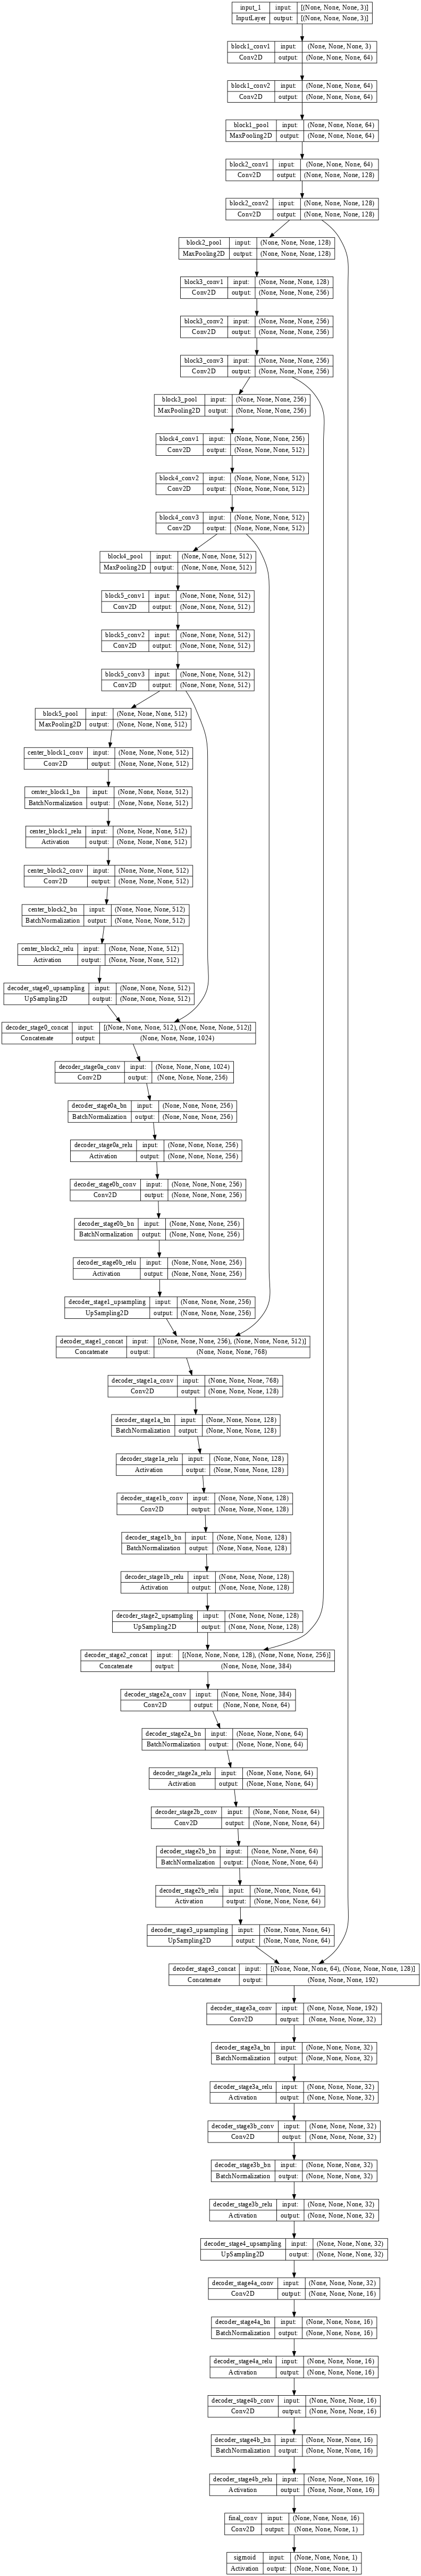

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=64)

In [ ]:
model.compile(loss=keras.losses.mean_squared_error, optimizer=keras.optimizers.Adam())

In [ ]:
#Training with 100 data
%%time
model.fit(x_train_100, y_train_100, batch_size=batch_size, epochs=epochs, verbose=1)

Epoch 1/100
7/7 [==============================] - 15s 316ms/step - loss: 0.5982
Epoch 2/100
7/7 [==============================] - 1s 76ms/step - loss: 0.4345
Epoch 3/100
7/7 [==============================] - 1s 76ms/step - loss: 0.3763
Epoch 4/100
7/7 [==============================] - 1s 77ms/step - loss: 0.3508
Epoch 5/100
7/7 [==============================] - 1s 76ms/step - loss: 0.3360
Epoch 6/100
7/7 [==============================] - 1s 76ms/step - loss: 0.3269
Epoch 7/100
7/7 [==============================] - 1s 77ms/step - loss: 0.3214
Epoch 8/100
7/7 [==============================] - 1s 77ms/step - loss: 0.3174
Epoch 9/100
7/7 [==============================] - 1s 75ms/step - loss: 0.3144
Epoch 10/100
7/7 [==============================] - 1s 76ms/step - loss: 0.3125
Epoch 11/100
7/7 [==============================] - 1s 77ms/step - loss: 0.3119
Epoch 12/100
7/7 [==============================] - 1s 76ms/step - loss: 0.3098
Epoch 13/100
7/7 [=============================

In [ ]:
%%time
preds_train = model.predict(x_train_100)
preds = model.predict(x_test)

6/6 [==============================] - 2s 310ms/step
CPU times: user 3.99 s, sys: 44 ms, total: 4.04 s
Wall time: 4.03 s


In [ ]:
%%time
err_train_3ch.append(percentage_err_3channels(preds_train, y_train_100))
err_test_3ch.append(percentage_err_3channels(preds, y_test))

R2Array_train.append(calculateR2(preds_train, y_train_100))
R2Array_test.append(calculateR2(preds, y_test))

MSEArray_train.append(calculateMSE(preds_train, y_train_100))
MSEArray_test.append(calculateMSE(preds, y_test))

print(R2Array_train)
print(R2Array_test)

reset_keras(model)

[0.18278807913711362]
[0.20073087796255176]
19671
CPU times: user 1.61 s, sys: 113 ms, total: 1.72 s
Wall time: 1.79 s


In [ ]:
#Train with 300 data points

model.fit(x_train_300, y_train_300, batch_size=batch_size, epochs=epochs, verbose=1)

Epoch 1/100
19/19 [==============================] - 4s 205ms/step - loss: 0.2680
Epoch 2/100
19/19 [==============================] - 2s 86ms/step - loss: 0.2676
Epoch 3/100
19/19 [==============================] - 2s 87ms/step - loss: 0.2674
Epoch 4/100
19/19 [==============================] - 2s 87ms/step - loss: 0.2673
Epoch 5/100
19/19 [==============================] - 2s 87ms/step - loss: 0.2670
Epoch 6/100
19/19 [==============================] - 2s 87ms/step - loss: 0.2669
Epoch 7/100
19/19 [==============================] - 2s 87ms/step - loss: 0.2670
Epoch 8/100
19/19 [==============================] - 2s 87ms/step - loss: 0.2667
Epoch 9/100
19/19 [==============================] - 2s 87ms/step - loss: 0.2668
Epoch 10/100
19/19 [==============================] - 2s 87ms/step - loss: 0.2665
Epoch 11/100
19/19 [==============================] - 2s 87ms/step - loss: 0.2664
Epoch 12/100
19/19 [==============================] - 2s 87ms/step - loss: 0.2665
Epoch 13/100
19/19 [====

In [ ]:
%%time
preds_train = model.predict(x_train_300)
preds = model.predict(x_test)

6/6 [==============================] - 0s 37ms/step
CPU times: user 824 ms, sys: 25 ms, total: 849 ms
Wall time: 918 ms


In [ ]:
err_train_3ch.append(percentage_err_3channels(preds_train, y_train_300))
err_test_3ch.append(percentage_err_3channels(preds, y_test))

R2Array_train.append(calculateR2(preds_train, y_train_300))
R2Array_test.append(calculateR2(preds, y_test))

MSEArray_train.append(calculateMSE(preds_train, y_train_300))
MSEArray_test.append(calculateMSE(preds, y_test))

In [ ]:
print(R2Array_train)
print(R2Array_test)

[0.18278807913711362, 0.233668550321353]
[0.20073087796255176, 0.20922978777674117]


In [ ]:
#Train with 500 data points

model.fit(x_train_500, y_train_500, batch_size=batch_size, epochs=epochs, verbose=1)

Epoch 1/100
32/32 [==============================] - 3s 87ms/step - loss: 0.2868
Epoch 2/100
32/32 [==============================] - 3s 88ms/step - loss: 0.2861
Epoch 3/100
32/32 [==============================] - 3s 86ms/step - loss: 0.2859
Epoch 4/100
32/32 [==============================] - 3s 85ms/step - loss: 0.2858
Epoch 5/100
32/32 [==============================] - 3s 85ms/step - loss: 0.2857
Epoch 6/100
32/32 [==============================] - 3s 85ms/step - loss: 0.2856
Epoch 7/100
32/32 [==============================] - 3s 85ms/step - loss: 0.2855
Epoch 8/100
32/32 [==============================] - 3s 85ms/step - loss: 0.2854
Epoch 9/100
32/32 [==============================] - 3s 86ms/step - loss: 0.2852
Epoch 10/100
32/32 [==============================] - 3s 86ms/step - loss: 0.2852
Epoch 11/100
32/32 [==============================] - 3s 85ms/step - loss: 0.2852
Epoch 12/100
32/32 [==============================] - 3s 85ms/step - loss: 0.2850
Epoch 13/100
32/32 [=====

In [ ]:
%%time
preds_train = model.predict(x_train_500)
preds = model.predict(x_test)

6/6 [==============================] - 0s 38ms/step
CPU times: user 992 ms, sys: 23 ms, total: 1.01 s
Wall time: 1.01 s


In [ ]:
err_train_3ch.append(percentage_err_3channels(preds_train, y_train_500))
err_test_3ch.append(percentage_err_3channels(preds, y_test))

R2Array_train.append(calculateR2(preds_train, y_train_500))
R2Array_test.append(calculateR2(preds, y_test))

MSEArray_train.append(calculateMSE(preds_train, y_train_500))
MSEArray_test.append(calculateMSE(preds, y_test))

print(R2Array_train)
print(R2Array_test)

[0.18278807913711362, 0.233668550321353, 0.218023160586816]
[0.20073087796255176, 0.20922978777674117, 0.21074299779840402]


In [ ]:
#Train with 700 data points

model.fit(x_train_700, y_train_700, batch_size=batch_size, epochs=epochs, verbose=1)

Epoch 1/100
44/44 [==============================] - 4s 87ms/step - loss: 0.2779
Epoch 2/100
44/44 [==============================] - 4s 86ms/step - loss: 0.2776
Epoch 3/100
44/44 [==============================] - 4s 86ms/step - loss: 0.2772
Epoch 4/100
44/44 [==============================] - 4s 86ms/step - loss: 0.2770
Epoch 5/100
44/44 [==============================] - 4s 86ms/step - loss: 0.2770
Epoch 6/100
44/44 [==============================] - 4s 86ms/step - loss: 0.2768
Epoch 7/100
44/44 [==============================] - 4s 87ms/step - loss: 0.2766
Epoch 8/100
44/44 [==============================] - 4s 88ms/step - loss: 0.2766
Epoch 9/100
44/44 [==============================] - 4s 86ms/step - loss: 0.2765
Epoch 10/100
44/44 [==============================] - 4s 86ms/step - loss: 0.2764
Epoch 11/100
44/44 [==============================] - 4s 86ms/step - loss: 0.2763
Epoch 12/100
44/44 [==============================] - 4s 86ms/step - loss: 0.2764
Epoch 13/100
44/44 [=====

In [ ]:
%%time
preds_train = model.predict(x_train_700)
preds = model.predict(x_test)

6/6 [==============================] - 0s 38ms/step
CPU times: user 2.95 s, sys: 29.1 ms, total: 2.98 s
Wall time: 2.96 s


In [ ]:
err_train_3ch.append(percentage_err_3channels(preds_train, y_train_700))
err_test_3ch.append(percentage_err_3channels(preds, y_test))

R2Array_train.append(calculateR2(preds_train, y_train_700))
R2Array_test.append(calculateR2(preds, y_test))

MSEArray_train.append(calculateMSE(preds_train, y_train_700))
MSEArray_test.append(calculateMSE(preds, y_test))

print(R2Array_train)
print(R2Array_test)

[0.18278807913711362, 0.233668550321353, 0.218023160586816, 0.23262876318811931]
[0.20073087796255176, 0.20922978777674117, 0.21074299779840402, 0.21038670756221578]


In [ ]:
#Train with 900 data points

model.fit(x_train_900, y_train_900, batch_size=batch_size, epochs=epochs, verbose=1)

Epoch 1/100
57/57 [==============================] - 5s 85ms/step - loss: 0.2730
Epoch 2/100
57/57 [==============================] - 5s 85ms/step - loss: 0.2727
Epoch 3/100
57/57 [==============================] - 5s 85ms/step - loss: 0.2723
Epoch 4/100
57/57 [==============================] - 5s 87ms/step - loss: 0.2721
Epoch 5/100
57/57 [==============================] - 5s 85ms/step - loss: 0.2721
Epoch 6/100
57/57 [==============================] - 5s 85ms/step - loss: 0.2720
Epoch 7/100
57/57 [==============================] - 5s 85ms/step - loss: 0.2718
Epoch 8/100
57/57 [==============================] - 5s 85ms/step - loss: 0.2718
Epoch 9/100
57/57 [==============================] - 5s 86ms/step - loss: 0.2717
Epoch 10/100
57/57 [==============================] - 5s 86ms/step - loss: 0.2717
Epoch 11/100
57/57 [==============================] - 5s 86ms/step - loss: 0.2716
Epoch 12/100
57/57 [==============================] - 5s 86ms/step - loss: 0.2715
Epoch 13/100
57/57 [=====

In [ ]:
%%time
preds_train = model.predict(x_train_900)
preds = model.predict(x_test)

6/6 [==============================] - 0s 38ms/step
CPU times: user 1.56 s, sys: 31.2 ms, total: 1.6 s
Wall time: 1.75 s


In [ ]:
err_train_3ch.append(percentage_err_3channels(preds_train, y_train_900))
err_test_3ch.append(percentage_err_3channels(preds, y_test))

R2Array_train.append(calculateR2(preds_train, y_train_900))
R2Array_test.append(calculateR2(preds, y_test))

MSEArray_train.append(calculateMSE(preds_train, y_train_900))
MSEArray_test.append(calculateMSE(preds, y_test))

print(R2Array_train)
print(R2Array_test)

[0.18278807913711362, 0.233668550321353, 0.218023160586816, 0.23262876318811931, 0.23971678929725423]
[0.20073087796255176, 0.20922978777674117, 0.21074299779840402, 0.21038670756221578, 0.2106329913441607]


In [ ]:
#Train with 1100 data points

model.fit(x_train_1100, y_train_1100, batch_size=batch_size, epochs=epochs, verbose=1)

Epoch 1/100
69/69 [==============================] - 6s 86ms/step - loss: 0.2802
Epoch 2/100
69/69 [==============================] - 6s 86ms/step - loss: 0.2801
Epoch 3/100
69/69 [==============================] - 6s 87ms/step - loss: 0.2797
Epoch 4/100
69/69 [==============================] - 6s 86ms/step - loss: 0.2795
Epoch 5/100
69/69 [==============================] - 6s 86ms/step - loss: 0.2793
Epoch 6/100
69/69 [==============================] - 6s 86ms/step - loss: 0.2792
Epoch 7/100
69/69 [==============================] - 6s 86ms/step - loss: 0.2792
Epoch 8/100
69/69 [==============================] - 6s 86ms/step - loss: 0.2791
Epoch 9/100
69/69 [==============================] - 6s 87ms/step - loss: 0.2791
Epoch 10/100
69/69 [==============================] - 6s 86ms/step - loss: 0.2790
Epoch 11/100
69/69 [==============================] - 6s 86ms/step - loss: 0.2790
Epoch 12/100
69/69 [==============================] - 6s 86ms/step - loss: 0.2790
Epoch 13/100
69/69 [=====

In [ ]:
%%time
preds_train = model.predict(x_train_1100)
preds = model.predict(x_test)

6/6 [==============================] - 0s 37ms/step
CPU times: user 1.82 s, sys: 38 ms, total: 1.86 s
Wall time: 2.97 s


In [ ]:
err_train_3ch.append(percentage_err_3channels(preds_train, y_train_1100))
err_test_3ch.append(percentage_err_3channels(preds, y_test))

R2Array_train.append(calculateR2(preds_train, y_train_1100))
R2Array_test.append(calculateR2(preds, y_test))

MSEArray_train.append(calculateMSE(preds_train, y_train_1100))
MSEArray_test.append(calculateMSE(preds, y_test))

print(R2Array_train)
print(R2Array_test)

[0.18278807913711362, 0.233668550321353, 0.218023160586816, 0.23262876318811931, 0.23971678929725423, 0.22494322281608353]
[0.20073087796255176, 0.20922978777674117, 0.21074299779840402, 0.21038670756221578, 0.2106329913441607, 0.21087389716006621]


In [ ]:
#Train with 1300 data points

model.fit(x_train_1300, y_train_1300, 
          batch_size=batch_size, epochs=epochs, verbose=1)

Epoch 1/100
82/82 [==============================] - 7s 85ms/step - loss: 0.2774
Epoch 2/100
82/82 [==============================] - 7s 86ms/step - loss: 0.2772
Epoch 3/100
82/82 [==============================] - 7s 86ms/step - loss: 0.2769
Epoch 4/100
82/82 [==============================] - 7s 86ms/step - loss: 0.2767
Epoch 5/100
82/82 [==============================] - 7s 86ms/step - loss: 0.2767
Epoch 6/100
82/82 [==============================] - 7s 86ms/step - loss: 0.2766
Epoch 7/100
82/82 [==============================] - 7s 86ms/step - loss: 0.2765
Epoch 8/100
82/82 [==============================] - 7s 86ms/step - loss: 0.2764
Epoch 9/100
82/82 [==============================] - 7s 86ms/step - loss: 0.2764
Epoch 10/100
82/82 [==============================] - 7s 85ms/step - loss: 0.2764
Epoch 11/100
82/82 [==============================] - 7s 86ms/step - loss: 0.2764
Epoch 12/100
82/82 [==============================] - 7s 85ms/step - loss: 0.2764
Epoch 13/100
82/82 [=====

In [ ]:
%%time
preds_train = model.predict(x_train_1300)
preds = model.predict(x_test)

6/6 [==============================] - 0s 37ms/step
CPU times: user 2.11 s, sys: 43 ms, total: 2.16 s
Wall time: 3 s


In [ ]:
err_train_3ch.append(percentage_err_3channels(preds_train, y_train_1300))
err_test_3ch.append(percentage_err_3channels(preds, y_test))

R2Array_train.append(calculateR2(preds_train, y_train_1300))
R2Array_test.append(calculateR2(preds, y_test))

MSEArray_train.append(calculateMSE(preds_train, y_train_1300))
MSEArray_test.append(calculateMSE(preds, y_test))

print(R2Array_train)
print(R2Array_test)

[0.18278807913711362, 0.233668550321353, 0.218023160586816, 0.23262876318811931, 0.23971678929725423, 0.22494322281608353, 0.22885351770245688]
[0.20073087796255176, 0.20922978777674117, 0.21074299779840402, 0.21038670756221578, 0.2106329913441607, 0.21087389716006621, 0.2110697514112776]


In [ ]:
#Train with 1620 data points

model.fit(x_train_1620, y_train_1620, batch_size=batch_size, epochs=epochs, verbose=1)

Epoch 1/100
102/102 [==============================] - 9s 85ms/step - loss: 0.2777
Epoch 2/100
102/102 [==============================] - 9s 86ms/step - loss: 0.2777
Epoch 3/100
102/102 [==============================] - 9s 86ms/step - loss: 0.2775
Epoch 4/100
102/102 [==============================] - 9s 86ms/step - loss: 0.2773
Epoch 5/100
102/102 [==============================] - 9s 86ms/step - loss: 0.2772
Epoch 6/100
102/102 [==============================] - 9s 86ms/step - loss: 0.2771
Epoch 7/100
102/102 [==============================] - 9s 86ms/step - loss: 0.2771
Epoch 8/100
102/102 [==============================] - 9s 85ms/step - loss: 0.2770
Epoch 9/100
102/102 [==============================] - 9s 85ms/step - loss: 0.2770
Epoch 10/100
102/102 [==============================] - 9s 85ms/step - loss: 0.2770
Epoch 11/100
102/102 [==============================] - 9s 86ms/step - loss: 0.2769
Epoch 12/100
102/102 [==============================] - 9s 85ms/step - loss: 0.2769
E

In [ ]:
%%time
preds_train = model.predict(x_train_1620)
preds = model.predict(x_test)

6/6 [==============================] - 0s 37ms/step
CPU times: user 2.59 s, sys: 63.3 ms, total: 2.65 s
Wall time: 2.64 s


In [ ]:
err_train_3ch.append(percentage_err_3channels(preds_train, y_train_1620))
err_test_3ch.append(percentage_err_3channels(preds, y_test))

R2Array_train.append(calculateR2(preds_train, y_train_1620))
R2Array_test.append(calculateR2(preds, y_test))

MSEArray_train.append(calculateMSE(preds_train, y_train_1620))
MSEArray_test.append(calculateMSE(preds, y_test))

print(R2Array_train)
print(R2Array_test)

[0.18278807913711362, 0.233668550321353, 0.218023160586816, 0.23262876318811931, 0.23971678929725423, 0.22494322281608353, 0.22885351770245688, 0.22682599742160342]
[0.20073087796255176, 0.20922978777674117, 0.21074299779840402, 0.21038670756221578, 0.2106329913441607, 0.21087389716006621, 0.2110697514112776, 0.21112747938752732]
